<a href="https://colab.research.google.com/github/Haseeb-oss-eng/CloudGIS/blob/main/CloudNativeGIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Apache Sedona Stack Band

In [1]:
#Download dependencies file to run Apache Sedona
!apt-get install openjdk-8-jdk-headless -qq > /dev/null  # Install Java
!wget https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz # Download Spark 3.5.3
!tar xf spark-3.5.3-bin-hadoop3.tgz  # Extract Spark
%pip install findspark  # Install findspark to locate Spark
%pip install apache-sedona[spark]  # Install Sedona with Spark dependencies

--2024-11-22 17:19:42--  https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400864419 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.3-bin-hadoop3.tgz’

spark-3.5.3-bin-had 100%[===================>] 382.29M   227MB/s    in 1.7s    

2024-11-22 17:19:44 (227 MB/s) - ‘spark-3.5.3-bin-hadoop3.tgz’ saved [400864419/400864419]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 857.4 kB/s eta 0:00:00


In [2]:
%pip install py4j==0.10.9.7  # Ensure this version matches your PySpark version

In [3]:
!apt-get update
!apt-get install -y libgdal-dev
%pip install --upgrade --force-reinstall 'sedona[sql,viz]'

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,172 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,734 kB]
Get:13 http://archive.ubuntu.com/ubuntu jamm

In [4]:
import os
import findspark

# Set the paths to Spark and Java
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"  # Update if your Spark path is different
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"  # Ensure this path matches your Java installation

# Initialize findspark
findspark.init()


In [5]:
from sedona.spark import *

# Initialize a basic SparkSession first
config = SedonaContext.builder()\
    .config("spark.jars.packages", "org.apache.sedona:sedona-spark-shaded-3.5_2.12:1.6.1,org.datasyslab:geotools-wrapper:1.6.1-28.2") \
    .getOrCreate()

# Register Sedona functions
sedona = SedonaContext.create(config)

# Check if Spark is working
print("Spark version:", sedona.version)


Spark version: 3.5.3


In [6]:
geotiff_df = sedona.read.format("binaryFile").load("/content/NDVI America.tif")
geotiff_df.createOrReplaceTempView("geotiff_table")

In [7]:
geotiff_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [8]:
raster_df = sedona.sql(f"SELECT RS_FromGeoTiff(content) AS raster FROM geotiff_table")
raster_df.createOrReplaceTempView("raster")

In [9]:
raster_df.printSchema()

root
 |-- raster: raster (nullable = true)



In [10]:
raster_metadata = sedona.sql("SELECT RS_MetaData(raster) as metadata from raster")
raster_metadata.show(truncate=False)
raster_metadata.createOrReplaceTempView("metadata")

+---------------------------------------------------------------------------------------------------------------------------+
|metadata                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------+
|{-96.17363431783598, 41.78962701724014, 539, 452, 0.008983152841195215, -0.008983152841195215, 0.0, 0.0, 4326, 1, 256, 256}|
+---------------------------------------------------------------------------------------------------------------------------+



In [11]:
raster_metadata.printSchema()

root
 |-- metadata: struct (nullable = true)
 |    |-- upperLeftX: double (nullable = false)
 |    |-- upperLeftY: double (nullable = false)
 |    |-- gridWidth: integer (nullable = false)
 |    |-- gridHeight: integer (nullable = false)
 |    |-- scaleX: double (nullable = false)
 |    |-- scaleY: double (nullable = false)
 |    |-- skewX: double (nullable = false)
 |    |-- skewY: double (nullable = false)
 |    |-- srid: integer (nullable = false)
 |    |-- numSampleDimensions: integer (nullable = false)
 |    |-- tileWidth: integer (nullable = false)
 |    |-- tileHeight: integer (nullable = false)



In [12]:
sedona.sql(f"SELECT RS_NumBands(raster) AS num_bands FROM raster").show()

+---------+
|num_bands|
+---------+
|        1|
+---------+



,"rs_asimage(raster, 500)"
0,

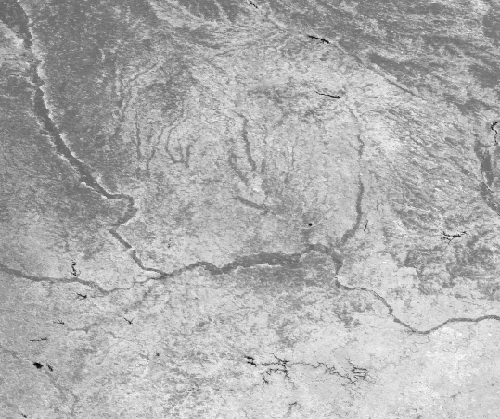

+-----------------------+
|rs_asimage(raster, 500)|
+-----------------------+
|   <img src="data:im...|
+-----------------------+



In [13]:
from sedona.spark import *

# Assign the DataFrame to htmlDf without calling show()
htmlDf = sedona.sql(f"SELECT RS_AsImage(raster,500) FROM raster")
# Display the image using SedonaUtils
SedonaUtils.display_image(htmlDf)

# Optionally, you can call show() separately to print the DataFrame content if needed.
htmlDf.show()

In [14]:
#get the pixel value from raster
sedona.sql(f"SELECT RS_Value(raster, ST_SetSRID(ST_Point(-96.17363431783598, 41.78962701724014),4326),1) AS pixel_value FROM raster").show(truncate=False)

+-----------+
|pixel_value|
+-----------+
|0.2641     |
+-----------+



In [ ]:
ndvi = sedona.sql("SELECT RS_MapAlgebra(raster, 'D', 'out = ((rast[3] - rast[2])/ (rast[3] + rast[2]));') AS ndvi FROM raster")
ndvi.createOrReplaceTempView("ndvi")

In [ ]:
sedona.sql("SELECT RS_SummaryStats(ndvi,'mean') AS stats FROM ndvi").show(truncate=False)

+-------------------+
|stats              |
+-------------------+
|0.19198961725652322|
+-------------------+



,"rs_asimage(ndvi, 500)"
0,

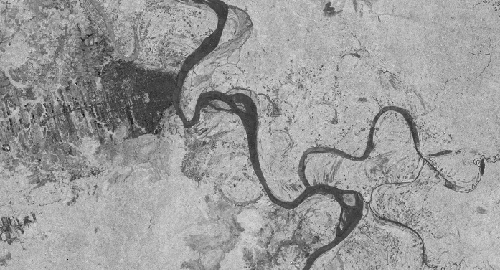

In [ ]:
htmlNDVIdf = sedona.sql("SELECT RS_AsImage(ndvi,500) FROM ndvi")
SedonaUtils.display_image(htmlNDVIdf)

In [ ]:
ndviF = sedona.sql("SELECT RS_AsGeoTiff(ndvi) FROM ndvi")
ndviF.createOrReplaceTempView("ndviF")

In [ ]:
dest_file = "/content/ndvi.tif"
ndviF.write.format("raster").save(dest_file)

#Apache Sedona Multi-Data

In [ ]:
import pyspark.sql.functions as f # Import the functions module and alias it as 'f'

geoMultiTiff = sedona.read.format('binaryFile').load('/content/*.tif')
# geoMultiTiff.createOrReplaceTempView("geotiff_table")
# geoMultiTiff.show()


+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/content/ban...|2024-11-13 16:37:...|1054136|[49 49 2A 00 BC 0...|
|file:/content/ban...|2024-11-13 16:37:...|1054136|[49 49 2A 00 BC 0...|
|file:/content/ban...|2024-11-13 16:37:...|1054136|[49 49 2A 00 BC 0...|
|file:/content/ban...|2024-11-13 16:37:...|1054136|[49 49 2A 00 BC 0...|
+--------------------+--------------------+-------+--------------------+



In [ ]:
geoMultiTiff = geoMultiTiff.withColumn("raster", f.expr("RS_FromGeoTiff(content)"))

In [ ]:
geoMultiTiff.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- raster: raster (nullable = true)



In [ ]:
geoMultiTiff.createOrReplaceTempView("geotiff_table")

In [ ]:
sedona.sql("SELECT RS_NumBands(raster) AS num_bands FROM geotiff_table").show()

+---------+
|num_bands|
+---------+
|        4|
|        4|
|        4|
|        4|
+---------+



In [ ]:
sedona.sql("SELECT RS_Metadata(raster) AS metadata FROM geotiff_table").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------+
|metadata                                                                                                       |
+---------------------------------------------------------------------------------------------------------------+
|{-74.722494154, -8.282107593, 697, 377, 8.084837560975725E-4, -8.084837559681719E-4, 0.0, 0.0, 4326, 4, 697, 2}|
|{-74.722494154, -8.282107593, 697, 377, 8.084837560975725E-4, -8.084837559681719E-4, 0.0, 0.0, 4326, 4, 697, 2}|
|{-74.722494154, -8.282107593, 697, 377, 8.084837560975725E-4, -8.084837559681719E-4, 0.0, 0.0, 4326, 4, 697, 2}|
|{-74.722494154, -8.282107593, 697, 377, 8.084837560975725E-4, -8.084837559681719E-4, 0.0, 0.0, 4326, 4, 697, 2}|
+---------------------------------------------------------------------------------------------------------------+



,image
0,
1,
2,
3,

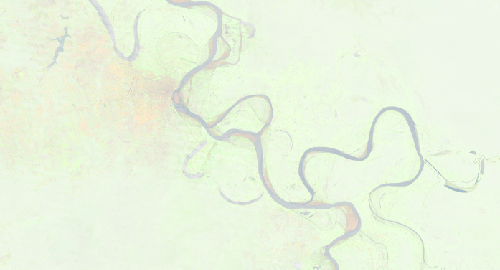
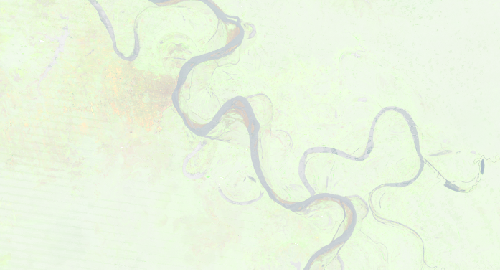
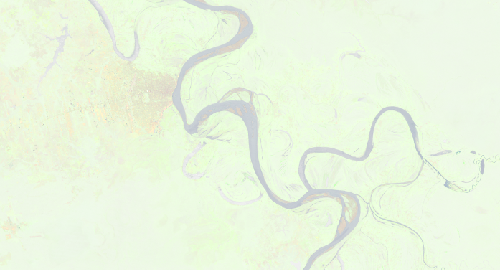
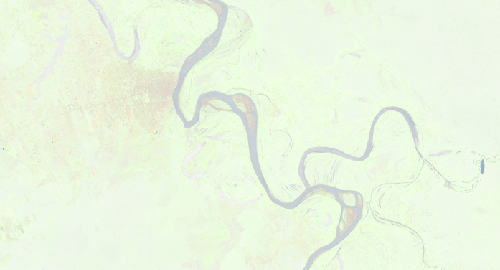

In [ ]:
htmlDf = sedona.sql("SELECT RS_AsImage(raster,500) AS image FROM geotiff_table")
SedonaUtils.display_image(htmlDf)

In [ ]:
sedona.sql("SELECT RS_Value(raster, ST_setSRID(ST_Point(-74.722494154, -8.282107593),4326),1) AS pixel_value FROM geotiff_table").show(truncate=False)
sedona.sql("SELECT RS_Value(raster, ST_setSRID(ST_Point(-74.722494154, -8.282107593),4326),2) AS pixel_value FROM geotiff_table").show(truncate=False)
sedona.sql("SELECT RS_Value(raster, ST_setSRID(ST_Point(-74.722494154, -8.282107593),4326),3) AS pixel_value FROM geotiff_table").show(truncate=False)
sedona.sql("SELECT RS_Value(raster, ST_setSRID(ST_Point(-74.722494154, -8.282107593),4326),4) AS pixel_value FROM geotiff_table").show(truncate=False)

+-----------+
|pixel_value|
+-----------+
|107.0      |
|105.0      |
|115.0      |
|105.0      |
+-----------+

+-----------+
|pixel_value|
+-----------+
|197.0      |
|209.0      |
|223.0      |
|176.0      |
+-----------+

+-----------+
|pixel_value|
+-----------+
|27.0       |
|22.0       |
|22.0       |
|24.0       |
+-----------+

+-----------+
|pixel_value|
+-----------+
|36.0       |
|30.0       |
|33.0       |
|32.0       |
+-----------+



In [ ]:
ndviDf = sedona.sql("SELECT RS_MapAlgebra(raster, 'D','out=((rast[3] - rast[2])/ (rast[3] + rast[2]));') AS ndvi FROM geotiff_table")
ndviDf.createOrReplaceTempView("ndvi")

In [ ]:
sedona.sql("SELECT RS_SummaryStats(ndvi,'mean') AS meanNDVI FROM ndvi").show(truncate=False)

+-------------------+
|meanNDVI           |
+-------------------+
|0.13735065319397355|
|NaN                |
|0.19241055901168236|
|0.19198961725652322|
+-------------------+



In [ ]:
sedona.sql("SELECT RS_SummaryStats(ndvi,'min') AS minNDVI FROM ndvi").show(truncate=False)

+-------------------+
|minNDVI            |
+-------------------+
|-0.2737430167597765|
|-0.3492063492063492|
|-0.2345679012345679|
|-0.2935323383084577|
+-------------------+



In [ ]:
sedona.sql("SELECT RS_SummaryStats(ndvi,'max') AS minNDVI FROM ndvi").show(truncate=False)

+------------------+
|minNDVI           |
+------------------+
|0.4074074074074074|
|0.423728813559322 |
|0.4090909090909091|
|0.5               |
+------------------+



#WUR Drone Apache Sedona Processing

In [ ]:
df = sedona.read.format("binaryFile").load("/content/ndvi.tif")
df.createOrReplaceTempView("raw_df")

In [ ]:
df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/content/ndv...|2024-11-21 11:01:...|1052576|[49 49 2A 00 08 0...|
+--------------------+--------------------+-------+--------------------+



In [ ]:
raster = sedona.sql("SELECT RS_FromGeoTiff(content) as raster FROM raw_df")
raster.createOrReplaceTempView("raster")

In [ ]:
sedona.sql("SELECT RS_Metadata(raster) as metadata FROM raster").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------+
|metadata                                                                                                       |
+---------------------------------------------------------------------------------------------------------------+
|{-74.722494154, -8.282107593, 697, 377, 8.084837560975725E-4, -8.084837559681719E-4, 0.0, 0.0, 4326, 1, 697, 2}|
+---------------------------------------------------------------------------------------------------------------+



,"rs_asimage(raster, 500)"
0,

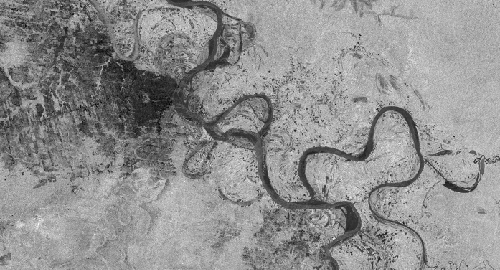

In [ ]:
html_df = sedona.sql("SELECT RS_AsImage(raster,500) FROM raster")
SedonaUtils.display_image(html_df)

In [ ]:
!git clone "https://git.wur.nl/mooc/mooc-drone02x-datasets-b.git"

Cloning into 'mooc-drone02x-datasets-b'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 10.87 KiB | 10.87 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Filtering content: 100% (4/4), 1.92 GiB | 7.22 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	M2.2_UAV_0807_MSP_barley_plots.zip

See: `git lfs help smudge` for more details.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.5 MB/s eta 0:00:00


INFO patool: Extracting /content/mooc-drone02x-datasets-b/M2.2_UAV_0807_MSP_barley_plots.zip ...
INFO:patool:Extracting /content/mooc-drone02x-datasets-b/M2.2_UAV_0807_MSP_barley_plots.zip ...
INFO patool: running /usr/bin/7z x -aou -o./Unpack_fp1450nc -- /content/mooc-drone02x-datasets-b/M2.2_UAV_0807_MSP_barley_plots.zip
INFO:patool:running /usr/bin/7z x -aou -o./Unpack_fp1450nc -- /content/mooc-drone02x-datasets-b/M2.2_UAV_0807_MSP_barley_plots.zip
INFO patool: ... /content/mooc-drone02x-datasets-b/M2.2_UAV_0807_MSP_barley_plots.zip extracted to `UAV_0807_MSP_barley_plots.tif'.
INFO:patool:... /content/mooc-drone02x-datasets-b/M2.2_UAV_0807_MSP_barley_plots.zip extracted to `UAV_0807_MSP_barley_plots.tif'.


'UAV_0807_MSP_barley_plots.tif'

In [ ]:
df = sedona.read.format("binaryFile").load("/content/UAV_0807_MSP_barley_plots.tif")
df.createOrReplaceTempView("raw_df")

In [ ]:
data = sedona.sql("SELECT RS_FromGeoTiff(content) AS raster FROM raw_df")
data.createOrReplaceTempView("raster_df")

In [ ]:
sedona.sql("SELECT RS_Metadata(raster) AS metadata FROM raster_df").show(truncate=False)

Py4JJavaError: An error occurred while calling o57.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4.0 (TID 3) (d3cee969018e executor driver): org.apache.spark.SparkException: The length of file:/content/UAV_0807_MSP_barley_plots.tif is 6185857425, which exceeds the max length allowed: 2147483647.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.fileLengthExceedsMaxLengthError(QueryExecutionErrors.scala:944)
	at org.apache.spark.sql.execution.datasources.binaryfile.BinaryFileFormat.$anonfun$buildReader$5(BinaryFileFormat.scala:117)
	at org.apache.spark.sql.execution.datasources.binaryfile.BinaryFileFormat.$anonfun$buildReader$5$adapted(BinaryFileFormat.scala:110)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.datasources.binaryfile.BinaryFileFormat.$anonfun$buildReader$3(BinaryFileFormat.scala:110)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:155)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:140)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:217)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: The length of file:/content/UAV_0807_MSP_barley_plots.tif is 6185857425, which exceeds the max length allowed: 2147483647.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.fileLengthExceedsMaxLengthError(QueryExecutionErrors.scala:944)
	at org.apache.spark.sql.execution.datasources.binaryfile.BinaryFileFormat.$anonfun$buildReader$5(BinaryFileFormat.scala:117)
	at org.apache.spark.sql.execution.datasources.binaryfile.BinaryFileFormat.$anonfun$buildReader$5$adapted(BinaryFileFormat.scala:110)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.datasources.binaryfile.BinaryFileFormat.$anonfun$buildReader$3(BinaryFileFormat.scala:110)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:155)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:140)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:217)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:279)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
